In [2]:
import pandas as pd
import ast
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from decimal import Decimal, InvalidOperation
df = pd.read_csv('rawdata.csv')
d1 = pd.read_csv('goldenTRANSMAT-all.csv')

In [3]:
def string_to_list(string_value):
    try:
        # Use `ast.literal_eval` to convert string to list safely
        return ast.literal_eval(string_value)
    except:
        return None

# Convert the strings into lists

def extract_with_symbols(parsed_value):
    # Check if parsed_value is a valid list/tuple with two components
    if isinstance(parsed_value, (list, tuple)) and len(parsed_value) == 2:
        # Join the unit component into a single string for searching
        unit_string = "".join(parsed_value[1]) if parsed_value[1] else ""
        # Check if the unit contains '/' or '^'
        if '/' in unit_string or '^' in unit_string:
            return parsed_value  # Return the parsed_value if it contains '/' or '^'
    return None  # Return None if no symbols are found

# Function to check if a string has balanced parentheses
def has_balanced_parentheses(string):
    """
    Checks if the parentheses in a string are balanced.
    Example: 'cm^3(STP)cm/cm^2scmHg' -> True (balanced)
             'cm^3(STPcm/cm^2scmHg)' -> False (unbalanced)
    """
    stack = []
    for char in string:
        if char == '(':
            stack.append(char)
        elif char == ')':
            if not stack:
                return False
            stack.pop()
    return len(stack) == 0

# Separate numerical part and units into different columns
def separate_number_and_unit(parsed_value):
    # Ensure parsed_value is a list/tuple with exactly 2 components
    if isinstance(parsed_value, (list, tuple)) and len(parsed_value) == 2:
        # Separate number and unit into two separate variables
        number_part = "".join(parsed_value[0]) if parsed_value[0] else None
        unit_part = "".join(parsed_value[1]) if parsed_value[1] else None
        return pd.Series([number_part, unit_part])
    return pd.Series([None, None])  # Return None if the structure is invalid


df['Parsed_Value'] = df['Original_Value'].apply(string_to_list)
df['Attached'] = df['Attached_Value'].apply(string_to_list)
df['Contains_Symbols'] = df['Parsed_Value'].apply(extract_with_symbols)

# Apply the separation based on whether Contains_Symbols has a value
df[['Number', 'Units']] = df['Parsed_Value'].apply(
    lambda x: separate_number_and_unit(x) if extract_with_symbols(x) is None else separate_number_and_unit(extract_with_symbols(x))
)


In [4]:

def clean_string(component_str, is_unit=False):
    if component_str:
        # Count opening and closing parentheses separately
        open_count = component_str.count('(')
        close_count = component_str.count(')')

        # Handling for the number part
        if not is_unit:
            component_str = component_str.replace(',', '')
            # If the number of "(" is odd, replace "(" with "x"
            if open_count % 2 != 0:
                component_str = component_str.replace('(', '×')
        
        # Handling for the unit part
        if is_unit:
            # Remove "STP" if it appears inside parentheses
            component_str = re.sub(r'\(STP\)', '', component_str)
            component_str = component_str.replace('percents','%')
            component_str = component_str.replace('wt.%','wt%')
            component_str = component_str.replace('kilograms','kg')
            component_str = component_str.replace('grams','g')
            component_str = component_str.replace('micrometers','μm')
            # If parentheses are unbalanced, drop all parentheses
            if open_count != close_count:
                component_str = component_str.replace('(', '').replace(')', '')
            else:
                # If parentheses are balanced, remove parentheses
                component_str = re.sub(r'\(|\)', '', component_str)
            
            
        return component_str
    return None


# Clean the Number and Unit columns separately after separation
df['Number'] = df['Number'].apply(lambda x: clean_string(x, is_unit=False))
df['Units'] = df['Units'].apply(lambda x: clean_string(x, is_unit=True))

## Number part: 
since the number part have several kinds of format like following instances, and also it is shown in string type, ____ makes string format into numerical format!
1. Scientific notation with uncertainty (114.4×10^−6±16.2×10^−6).
2. Standard notation with uncertainty (1.84±0.08×10^−5).
3. Scientific notation or standard ranges (0.232×10^−10–1.160×10^−10, 0.01–2).
4. Scientific notation without uncertainty (0.08×10^−5,10^−5)
5. Standard number with uncertainty (14.57±0.18)
6. Single values (35)
- cm^3mm/(m^224hatm) and cm^3mm/(m^2atmday) are the same unit, so convert cm^3mm/(m^224hatm) into cm^3mm/(m^2atmday) [24hr->day]
- molm^−1Pa^−1s^−1 and molm^−1s^−1Pa^−1 are the same with dif sequence, so molm^−1Pa^−1s^−1 converted into molm^−1s^−1Pa^−1


In [5]:

def parse_value(value_str, target ):
    
    if pd.isnull(value_str):  # Handle NaN values
        return None, None, None, target  # Return three None values for consistency
    
    if value_str == 'Five':
        return 5.0, 0.0, '6', target
    if value_str == 'Two':
        return 2.0, 0.0, '6', target
    try:
        # Step 1: Replace special characters for scientific notation
        formatted_value = value_str.replace("×", "*").replace("^", "**").replace("−", "-").replace("–", "-").replace("/", "-")

        # Define regular expression patterns for different cases
        patterns = [
            # Case 1: Scientific notation with uncertainty (e.g., 114.4×10^−6±16.2×10^−6)
            (r"([0-9.]+)\*(10\*\*[-+]?[0-9]+)±([0-9.]+)\*(10\*\*[-+]?[0-9]+)", "1"),
            # Case 2: Standard value with uncertainty in scientific form (e.g., 1.84±0.08×10^−5)
            (r"([0-9.]+)±([0-9.]+)\*(10\*\*[-+]?[0-9]+)", "2"),
            # Case 3: Scientific notation or standard ranges (e.g., 0.232×10^−10–1.160×10^−10 or 0.01–2)
            (r"([0-9.]+)\*(10\*\*[-+]?[0-9]+)-([0-9.]+)\*(10\*\*[-+]?[0-9]+)", "3"),
            (r"([0-9.]+)-([0-9.]+)", "3"),
            # Case 4: Single scientific notation value (e.g., 4×10^−16, 10^−12)
            (r"([0-9.]+)\*(10\*\*[-+]?[0-9]+)", "4"),
            (r"(10\*\*[-+]?[0-9]+)", "4"),
            # Case 5: Standard number with uncertainty (e.g., 1.84±0.08)
            (r"([0-9.]+)±([0-9.]+)", "5"),
            # Case 6: Single number (e.g., 35)
            (r"^([0-9.]+)$", "6")
        ]
        
        # Step 2: Match patterns and extract values
        for pattern, case_type in patterns:
            match = re.match(pattern, formatted_value)
            if match:
                groups = match.groups()
                
                # Case 1: Scientific notation with uncertainty (4 groups)
                if len(groups) == 4 and case_type == "1":
                    mean = Decimal(groups[0]) * Decimal(eval(groups[1]))
                    uncertainty = Decimal(groups[2]) * Decimal(eval(groups[3]))
                    return float(mean), float(uncertainty), case_type, target
                
                # Case 2: Standard value with uncertainty in scientific form (3 groups)
                elif len(groups) == 3 and case_type == "2":
                    mean = Decimal(groups[0]) * Decimal(eval(groups[2]))
                    uncertainty = Decimal(groups[1]) * Decimal(eval(groups[2]))
                    return float(mean), float(uncertainty), case_type, target
                
                # Case 3: Ranges (Scientific or Standard)
                elif case_type == "3":
                    if len(groups) == 4:  # Scientific notation range
                        lower = Decimal(str(eval(f"{groups[0]}*{groups[1]}")))
                        upper = Decimal(str(eval(f"{groups[2]}*{groups[3]}")))
                    else:  # Standard range
                        lower = Decimal(groups[0])
                        upper = Decimal(groups[1])
                    
                    # Check for "relative humidity difference" in target to compute difference
                    if target in ["relative humidity difference" , "relative_humidity"]:
                        mean = upper - lower  # Calculate difference for RH difference
                        uncertainty = 0.0
                        target = "relative humidity difference"
                    else:
                        mean = (lower + upper) / 2  # Calculate average for other ranges
                        uncertainty = abs(upper - lower) / 2
                    
                    return float(mean), float(uncertainty), case_type, target
                
                # Case 4: Single scientific notation value (e.g., 4×10^−16 or 10**-12)
                elif len(groups) in [1, 2] and case_type == "4":
                    if len(groups) == 2:  # e.g., 4×10^−16
                        mean = Decimal(groups[0]) * Decimal(eval(groups[1]))
                    else:  # e.g., 10**-12
                        mean = Decimal(eval(groups[0]))
                    return float(mean), 0.0, case_type, target
                
                # Case 5: Standard number with uncertainty (e.g., 1.84±0.08)
                elif len(groups) == 2 and case_type == "5":
                    mean = Decimal(groups[0])
                    uncertainty = Decimal(groups[1])
                    return float(mean), float(uncertainty), case_type, target
                
                # Case 6: Single number (1 group)
                elif len(groups) == 1 and case_type == "6":
                    return float(Decimal(groups[0])), 0.0, case_type, target

    except (InvalidOperation, SyntaxError, TypeError, ValueError) as e:
        print(f"Error processing value '{value_str}': {e}")
        return None, None, None, target  # Ensure three None values are returned

    # If the value does not match any pattern, return three None values
    return None, None, None, target

# Apply the parsing function to each value in the 'Number' series
Number_df = df.apply(lambda row : pd.Series(parse_value(row['Number'], row['Target']), index=["Mean", "Uncertainty","Case Type", "Target_2"]), axis = 1)
# Number_df = df['Number'].apply(lambda x: pd.Series(parse_value(x), index=["Mean", "Uncertainty","Case Type"]))

# Combine the original series with the parsed values -> for checking
# Number_df = pd.concat([df['Number'].rename("Original Value"), Number_df], axis=1)

# Combine the original series with the parsed values
df = pd.concat([df, Number_df], axis=1)

In [6]:
# Function to handle negative powers and convert them to the desired format
conversion_dict = {
    "gm^−1s^−1Pa": "g/m/s/Pa",
    "gm^−1s^−1Pa^−1": "g/m/s/Pa",
    "gm^−2day^−1": "g/m2day",
    "molm^−1Pa^−1s^−1" : "mol/m/Pa/s",
    "molm^−1s^−1Pa^−1" : "mol/m/Pa/s",
    "gmPasm^2^−1" : "gm/Pasm2",
    "gkg^−1" : 'g/kg',
    "kgm^−2s^−1" : "kg/m2/s"

}

converted_series = df['Units'].replace(conversion_dict)
converted_series.unique()
print(len(converted_series.unique()))

184


In [7]:
# Function to combine denominator parts into a single expression
def format_denominator(unit_str):
    if unit_str is None:
        return None  # Return None if the unit string is None
    # Identify and isolate the numerator and denominator parts
    if '/' in unit_str:
        parts = unit_str.split('/')
        numerator = parts[0]  # The numerator part is always the first element
        denominator = ''.join(parts[1:])  # Concatenate all denominator parts
        formatted_unit = f"{numerator}/{denominator}"
    else:
        formatted_unit = unit_str
    return formatted_unit

df['clean_Units'] = converted_series.apply(format_denominator)

df.loc[df['Case Type'].isnull(), 'clean_Units'] = None

In [ ]:
df.head()

,Unnamed: 0,id,Doc,Target,Original_Value,Attached_Value,Type,Annotator,DOI,Parsed_Value,Attached,Contains_Symbols,Number,Units,Mean,Uncertainty,Case Type,Target_2,clean_Units
0,0,0,Barrier and surface properties of chitosan-coa...,permeability,"(['3400'], ['cm', '^', '3', 'mm', '/', '(', 'm...","['carbon', 'dioxide']",QUANTITY,1,https://doi.org/10.1016/j.carbpol.2006.02.005,"([3400], [cm, ^, 3, mm, /, (, m, ^, 2, atm, da...","[carbon, dioxide]","([3400], [cm, ^, 3, mm, /, (, m, ^, 2, atm, da...",3400,cm^3mm/m^2atmday,3400.000,0.0,6,permeability,cm^3mm/m^2atmday
1,1,1,Barrier and surface properties of chitosan-coa...,permeability,"(['40,000'], ['cm', '^', '3', '/', '(', 'm', '...","['carbon', 'dioxide']",QUANTITY,1,https://doi.org/10.1016/j.carbpol.2006.02.005,"([40,000], [cm, ^, 3, /, (, m, ^, 2, atm, day,...","[carbon, dioxide]","([40,000], [cm, ^, 3, /, (, m, ^, 2, atm, day,...",40000,cm^3/m^2atmday,40000.000,0.0,6,permeability,cm^3/m^2atmday
2,2,2,Barrier and surface properties of chitosan-coa...,permeability,"(['10'], ['cm', '^', '3', 'mm', '/', '(', 'm',...","['carbon', 'dioxide']",QUANTITY,1,https://doi.org/10.1016/j.carbpol.2006.02.005,"([10], [cm, ^, 3, mm, /, (, m, ^, 2, atm, day,...","[carbon, dioxide]","([10], [cm, ^, 3, mm, /, (, m, ^, 2, atm, day,...",10,cm^3mm/m^2atmday,10.000,0.0,6,permeability,cm^3mm/m^2atmday
3,3,3,Barrier and surface properties of chitosan-coa...,permeability,"(['0.001'], ['cm', '^', '3', 'mm', '/', '(', '...","['carbon', 'dioxide']",QUANTITY,1,https://doi.org/10.1016/j.carbpol.2006.02.005,"([0.001], [cm, ^, 3, mm, /, (, m, ^, 2, atm, d...","[carbon, dioxide]","([0.001], [cm, ^, 3, mm, /, (, m, ^, 2, atm, d...",0.001,cm^3mm/m^2atmday,0.001,0.0,6,permeability,cm^3mm/m^2atmday
4,4,4,Barrier and surface properties of chitosan-coa...,permeability,"(['cm', '^', '3', 'mm', '/', '(', 'm', '^', '2...",['permeability'],QUANTITY,1,https://doi.org/10.1016/j.carbpol.2006.02.005,"([cm, ^, 3, mm, /, (, m, ^, 2, atm, day, )], [...",[permeability],None,cm^3mm/×m^2atmday),carbondioxide,NaN,NaN,None,permeability,None


In [9]:
df.columns

Index(['Unnamed: 0', 'id', 'Doc', 'Target', 'Original_Value', 'Attached_Value',
       'Type', 'Annotator', 'DOI', 'Parsed_Value', 'Attached',
       'Contains_Symbols', 'Number', 'Units', 'Mean', 'Uncertainty',
       'Case Type', 'Target_2', 'clean_Units'],
      dtype='object')

In [10]:
df[['Doc','Target', 'Type','Number', 'Units', 'Mean','Target_2', 'clean_Units']]
print(df['Target'].value_counts())

impact_factor_component         581
packaging                       521
component_qty_value             394
permeability                    150
temperature                      67
relative_humidity                66
method                           55
thickness                        50
h2o_permeability                 21
o2_permeability                  21
partial_pressure_difference      18
co2_permeability                  6
relative humidity difference      4
Name: Target, dtype: int64


In [ ]:
# Dictionary for units that require numerical conversion (factor not equal to 1)
conversion_units = {
    # time 
    'day': {'factor': 24 * 60 * 60, 'replacement': 's'},
    '24h': {'factor': 24 * 60 * 60, 'replacement': 's'},
    'min': {'factor': 60, 'replacement': 's'},
    # pressure
    'cmHg': {'factor': 1/1333.22, 'replacement': 'Pa'},
    'mmHg': {'factor': 1/133.322, 'replacement': 'Pa'},
    'barrer': {'factor': 1e-6/1333.22, 'replacement': 'cm^3cm/m^2Pas'},
    'Barrers': {'factor': 1e-6/1333.22, 'replacement': 'cm^3cm/m^2Pas'},
    'atm': {'factor': 101325, 'replacement': 'Pa'},
    'kPa': {'factor': 1000, 'replacement': 'Pa'},
    'bar' : {'factor': 100000, 'replacement': 'Pa'},
    'bars' : {'factor': 100000, 'replacement': 'Pa'},
    'psig' : {'factor': 6894.75728, 'replacement': 'Pa'},
    # length 
    'μm': {'factor': 1e-6, 'replacement': 'm'},
    'nm': {'factor': 1e-9, 'replacement': 'm'},
    'mil' :{'factor': 25.4e-6, 'replacement': 'm'},
    '10^5': {'factor': 1e5, 'replacement': ''},
    'cm^2': {'factor': 1e-4, 'replacement': 'm^2'},
    'ng': {'factor': 1e-9, 'replacement': 'g'},
    
    

}

# Dictionary for units that only need to be unified (factor equal to 1)
unify_units = {
    'cc': 'cm^3',
    'ml':'mL',
    '×': '',
    'm^2sPa': 'm^2Pas',
    'sm^2Pa': 'm^2Pas',
    'Pasm2': 'm^2Pas',
    'Pasm^2' : 'm^2Pas',
    'msPa': 'mPas',
    'M':'mol/l'
    }

speical_case = {
    'cm^3mm': {'factor': 1e-1, 'replacement': 'cm^3cm'},
    'cm^3m': {'factor': 1e2, 'replacement': 'cm^3cm'},
    'gmm' : {'factor': 1e-2, 'replacement': 'gm'},
    'kg' : {'factor': 1e3, 'replacement': 'g'},
}


In [12]:

def update_number_and_units(row):
    unit = row['clean_Units']
    number = row['Mean']
    original_unit = unit
    original_number = number

    # If unit or number is NaN, return the original values
    if pd.isna(unit) or pd.isna(number):
        return pd.Series([number, unit], index=['Updated_Number', 'Updated_Units'])

    # Split unit into numerator and denominator
    if '/' in unit:
        parts = unit.split('/')
        numerator = parts[0]
        denominator = parts[1]
    else:
        numerator = unit
        denominator = ''

    # Process numerator using simple substring matching
    for key, value in conversion_units.items():
        if key in numerator:
            # Multiply the number by the factor
            number *= value['factor']
            # Replace the key in the numerator unit
            numerator = numerator.replace(key, value['replacement'])

    # Process denominator using simple substring matching
    for key, value in conversion_units.items():
        if key in denominator:
            # Divide the number by the factor
            number /= value['factor']
            # Replace the key in the denominator unit
            denominator = denominator.replace(key, value['replacement'])
    
    for key, replacement in unify_units.items():
        if key in numerator:
            # Replace the key in the numerator unit
            numerator = numerator.replace(key, replacement)
        if key in denominator:
            # Replace the key in the denominator unit
            denominator = denominator.replace(key, replacement)
    
    if denominator == 'mPas':
        # print("be4:" + numerator + '/' + denominator )
        denominator = denominator.replace('mPas','m^2Pas')
        numerator = numerator + 'm'
        # print("after:" +numerator + '/' + denominator )
    
    for key, value in speical_case.items():
        if key in numerator:
            # print("be4:" + numerator + '/' + denominator )
            # Multiply the number by the factor
            number *= value['factor']
            # Replace the key in the numerator unit
            numerator = numerator.replace(key, value['replacement'])        
            # print("after:" + numerator + '/' + denominator )
    
    
    # Reconstruct the unit
    numerator = numerator.strip()
    denominator = denominator.strip()
    if denominator:
        unit = f"{numerator}/{denominator}"
    else:
        unit = numerator
    
    # Return updated values
    return pd.Series([number, unit], index=['Updated_Number', 'Updated_Units'])


# Create a copy of the original DataFrame to show the before and after values
df[['Updated_Number', 'Updated_Units']] = df.apply(update_number_and_units, axis=1)
df['Updated_Units'] = df['Updated_Units'].str.replace('^','',regex = False)
# Display the combined DataFrame with both original and updated columns
combined_df = df[['Mean', 'clean_Units', 'Updated_Number', 'Updated_Units']]


In [13]:
combined_df['Updated_Units'].unique()

array(['cm3cm/m2Pas', 'cm3/m2Pas', nan, 'gm/m2Pas', 'g/m2s', 'molm/m2Pas',
       'g', 'wt%', '%', 'g/m2', 'ca.', 'vol%', 'mL', 'g/kg', 'drops',
       'mol', 'mol/l', 'l', 'equiv.', 'pph', 'parts', 'm3m/m2Pas',
       'cm3/m2s', 'Pa', 'Pas', '°C', 'm', 'mm'], dtype=object)

In [14]:
# Extending your existing code to create columns after each transformation step
def update_number_and_units_with_steps(row):
    unit = row['clean_Units']
    number = row['Mean']
    
    # Create initial columns for original values
    number_1 = number
    unit_1 = unit

    # If unit or number is NaN, return the original values
    if pd.isna(unit) or pd.isna(number):
        return pd.Series([number, unit, number, unit], index=['mean_1', 'unit_1', 'mean_2', 'unit_2'])

    # Split unit into numerator and denominator
    if '/' in unit:
        parts = unit.split('/')
        numerator = parts[0]
        denominator = parts[1]
    else:
        numerator = unit
        denominator = ''

    # Step 1: Process numerator using conversion_units dictionary
    for key, value in conversion_units.items():
        if key in numerator:
            number_1 *= value['factor']
            numerator = numerator.replace(key, value['replacement'])

    # Step 1: Process denominator using conversion_units dictionary
    for key, value in conversion_units.items():
        if key in denominator:
            number_1 /= value['factor']
            denominator = denominator.replace(key, value['replacement'])
    
    # Step 1 Output: Updated mean_1 and unit_1
    unit_1 = numerator + '/' + denominator if denominator else numerator
    
    # Step 2: Unifying units
    for key, replacement in unify_units.items():
        if key in numerator:
            numerator = numerator.replace(key, replacement)
        if key in denominator:
            denominator = denominator.replace(key, replacement)
    
    # Special case for 'mPas' denominator
    if denominator == 'mPas':
        denominator = 'm^2Pas'
        numerator += 'm'

    # Step 3: Special case handling from speical_case dictionary
    number_2 = number_1  # Carry forward from step 1
    for key, value in speical_case.items():
        if key in numerator:
            number_2 *= value['factor']
            numerator = numerator.replace(key, value['replacement'])

    # Step 3 Output: Final mean_2 and unit_2
    unit_2 = numerator + '/' + denominator if denominator else numerator
    # print(unit_1, unit_2)
    # Return all steps
    return pd.Series([number, unit, number_1, unit_1, number_2, unit_2], index=['Mean', 'clean_Units', 'mean_1', 'unit_1', 'mean_2', 'unit_2'])


In [ ]:
## the cell is used to check the calculation correctness
df[['Mean', 'clean_Units', 'mean_1','mean_2', 'unit_1' , 'unit_2']] = df.apply(update_number_and_units_with_steps, axis=1)
df['unit_2'] = df['unit_2'].str.replace('^','',regex = False)
c_df = df[['Mean', 'clean_Units', 'mean_1', 'unit_1', 'mean_2', 'unit_2']]
## check conversion 
c_df['check_1'] = c_df['mean_1'] / c_df['Mean']
c_df['check_2'] = c_df['mean_2'] / c_df['mean_1']
c_df = c_df[['Mean', 'clean_Units', 'mean_1', 'check_1','unit_1',  'mean_2', 'check_2', 'unit_2']]

/var/folders/qs/8x1gpygd3nl0wldh8bphz0f80000gn/T/ipykernel_19165/1953178691.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_df['check_1'] = c_df['mean_1'] / c_df['Mean']
/var/folders/qs/8x1gpygd3nl0wldh8bphz0f80000gn/T/ipykernel_19165/1953178691.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_df['check_2'] = c_df['mean_2'] / c_df['mean_1']


In [17]:
df['elements'] = df.apply(lambda row: ' '.join([x.replace('(', '').replace(')', '') for x in row['Parsed_Value']])
                          if pd.isna(row['Updated_Number']) and pd.isna(row['Updated_Units']) and isinstance(row['Parsed_Value'], list)
                          else np.nan, axis=1)


In [18]:
def join_elements(val):
    if isinstance(val, list):
        return ' '.join(val)
    return np.nan

df['Attached'] = df['Attached'].apply(join_elements)

In [ ]:
#unify the elements
elements_abb_dict = {
    
    '1 - Methyl - 2 - pyrrolidone': 'NMP',
    '1,4 - BD': 'BDO',
    '1,4 - Butanediol': 'BDO',
    '1,4 - butanediol': 'BDO',
    '11S': 'SPI 11S',
    '2 – 2 - diphenyl - 1 - picryhydrazyl' : 'DPPH',
    '7S': 'SPI 7S', 
    '4,4 ′ - diaminodiphenyl sulfone': 'DDS',
    '4032D': 'PLA 4032D',
    '4060D': 'PLA 4060D',
    'hdpe' : 'HDPE',
    'A . pavonina': 'AP',
    'C . pulcherima': 'CP',
    'C . pulcherrima': 'CP',
    'C15A' : 'OMMT',
    'cloisite  30b': 'OMMT',
    'cloisite  30b nanoclay': 'OMMT',
    'C6A': 'MMT',
    'poly  ethylene glycol ': 'PEG',
    'polyethylene glycol' : 'PEG',
    'polyethyleneglycol' : 'PEG',
    'GLY': 'glycerol',
    'polycaprolactone' : 'PCL',
    'M2  HT  2 - 140': 'organoclay',
    'N , N-dimethylformamide': 'DMF',
    'OX-TRAN 2  MOCON , Minneapolis , MN , USA  according to the ASTM D3985 standard' : 'ASTM D3985',
    # 'OMMT': 'OMMT',
    'OMMTs': 'OMMT',
    'acid detergent fibres': 'ADF',
    'acid detergent lignin': 'ADL',
    'boron nitride': 'BN',
    'butyl methacrylate': 'BMA',
    'buthylated hydroxytoluene' : 'BHT',
    'cabosil ts 530': 'hydrophobic fumed silica',
    'carboxylmethyl cellulose': 'CMC',
    'cellulose nanocrystal': 'CNC',
    'cellulose nanocrystals': 'CNC',
    'Cloisite  Na +': 'Na-MMT',
    'CL-UE400' : 'OMMT',
    'cloisite 15a': 'OMMT',
    'cloisite 20a': 'OMMT',
    'Cloisite 20A': 'OMMT',
    'film' : '',
    'method' : '',
    'Method' : '',
    'standard' : '',
    'Standard' : '',
    'Cloisite 30B': 'OMMT',
    'cloisite 30b ': 'OMMT',
    'cloisite 6a': 'MMT',
    'cloisite-na +': 'Na-MMT',
    'corn zein': 'CZ',
    'corn–zein':'CZ',
    'CORN-ZEIN': 'CZ',
    'CN-C34' : 'MMT',
    '30B': 'OMMT',
    'dibutyltindilauryate': 'DBTDL',
    'diglycidyl ether of bisphenol a': 'DGEBA',
    'dimethyl formamide': 'DMF',
    'dimethyl terephthalate': 'DMT',
    'poly  ethylene terephthalate ': 'PET',
    'ethylene glycol' : 'EG',
    'high-density polyethylene': 'HDPE',
    'isplen pp051': 'isotactic PP',
    'jeffamine': 'polyoxyalkyleneamine',
    'low density polyethylene': 'LDPE',
    'low-density polyethylene': 'LDPE',
    ', LDPE film': 'LDPE',
    'methylcellulose': 'MC',
    'microcrystalline cellulose': 'MCC',
    'mixed matrix membrane': 'MMM',
    'montmorillonite': 'MMT',
    'nanofil 757': 'Na-MMT',
    'nanofil 804': 'Na-MMT',
    'neutral detergent fibres': 'NDF',
    'organo-modified ' : 'O',
    'organo-': 'O',
    'polyhydroxyalkanoates' : 'PHA',
    'O-MMT' : 'OMMT',
    'poly  3 - hydroxybutyrate-co-valerate': 'PHBV',
    'ingeo  ™ 4060d' : 'PLA 4060D',
    'polystyrene' : 'PS',
    'cellulose-derivative-' : 'MC-',
    'poly  lactic acid ': 'PLA',
    'poly  lactide': 'PLA',
    'poly  methyl metacrylate': 'PMMA',
    'poly  vinyl chloride': 'PVC',
    'polyvinyl chloride' : 'PVC',
    'poly-l-lactide': 'PLLA',
    'poly-lactic acid': 'PLA',
    'polyamide 6': 'PA6',
    'polyethersulfone': 'PES',
    'polyethylene': 'PE',
    'polyethylene terephthalate': 'PET',
    'polylactide': 'PLA',
    'polymer of intrinsic microporosity': 'PIM',
    'polymers of intrinsic microporosity': 'PIM',
    'poly  methyl methacrylate' : 'PMMA',
    'polyprolene': 'PP',
    'polypropylene': 'PP',
    'pristine': 'CNC',
    'polyurethane' : 'PU',
    'pre-intercalated compound' : 'PIC',
    ' glycol': 'G',
    # 'sic': 'SiC',
    'silicon carbide': 'SiC',
    'sodium ': 'Na-',
    'alox' : 'AlOx',
    'naoh' : 'NaOH',
    'D 3985' : ' D3985',
    'astm' : 'ASTM',
    '-e96' : ' E96',
    '-E96' : ' E96', 
    'E 96' : 'E96',
    'E - 96' : 'E96',
    'F 316': 'F316',
    ', 1995a' : 'E96 - 95',
    ', 1995b' : 'D3985 - 95',
    'D - 1434' : 'D1434',
    'D 3363 ' : 'D3363',
    'MOCON  Modern Controls Inc . , USA  Permatran-W @ 398' : 'ASTM E398',
    'cocoamphodipropionate' : 'K2',
    'cocamidopropylhydroxysultaine' : 'C50',
    'C20H42N2O5S' : 'C50',
    'CL120' : 'MMT',
    'PEGs' : 'PEG',
    'cl120' : 'MMT',
    'acids' : 'acid',
    'PLAs' : 'PLA',
    'galactomannan' : 'galactomannans',
    'CNCs' : 'CNC',
    'equilibrium modified atmosphere packaging': 'EMAP',
    'testing' : '',
    'micro perforated' : 'microperforated',
    'SPIs' : 'SPI',
    'whey protein isolate' : 'WPI',
    'soluble soybean polysaccharide': 'SSPS',
    'soy protein isolate': 'SPI',
    'soy protein isolates': 'SPI',
    'surfactant-modified ': 's-',
    'surfactant modified ': 's-',
    'methyl methacrylate' : "MMA",
    'surlyn ionomer': 'Na-ionomer of poly  ethylene-co-methacrylic acid',
    'tetra-n-butyl ammonium hydroxide': 'TBA',
    'tetraethoxysilane': 'TEOS',
    'tio2': 'TiO2',
    'nanocomposites' : 'nanocomposite',
    'titanium dioxide': 'TiO2',
    'wheat gluten': 'WG',
    'papers' : 'paper',
    'wheat straw': 'WSF',
    'wheat straw fibres': 'WSF',
    'zrp': 'ZrP',
    'SiC loading' : 'SiC',
    'WVPs' : 'WVP',
    ':': '-',
    '-' : ' ',

    }


In [20]:
def convert_case(value):
    if isinstance(value, str):  # Check if the value is a string
        value = value.replace('^', '').replace('®', '')
        if value[:2].isupper():  # If both first and second letters are capital, keep unchanged
            return value
        elif value[0].isupper():  # If only the first letter is capital, convert to lowercase
            return value.lower()
    return value  # Return as is for non-strings or if no condition matches

# Apply the conversion to each value in the Series
df['elements'] = df['elements'].apply(lambda x: convert_case(x))
df['Attached'] = df['Attached'].apply(lambda x: convert_case(x))

In [ ]:
def apply_conversion(value, conversion_dict):
    if isinstance(value, str):
        value = value.replace('films','film')
        value = value.replace('4000','PEG4000') if value == "4000" else value
        value = value.replace('8000','PEG8000') if value == "8000" else value
        value = value.replace('gly', 'glycerol') if value == "gly" else value
        value = value.replace('na MMT', 'Na MMT') if value == "na MMT" else value
        value = value.replace('palmitic', 'palmitic acid') if value == "palmitic" else value
        value = value.replace('stearic', 'stearic acid') if value == "stearic" else value
        value = value.replace('sic', 'SiC') if value == "sic" else value
        value = value.replace('cloisite na + ', 'Na MMT') if value == "cloisite na +" else value
        value = value.replace('cloisite-na  + ', 'Na MMT') if value == "cloisite-na + " else value
        value = value.replace('cloisite 30b', 'OMMT')
        for old, new in conversion_dict.items():
            value = value.replace(old, new)
    
    return value


# Apply the conversion to each value in the list
df['elements_2'] = df['elements'].apply(lambda x: apply_conversion(x, elements_abb_dict))
# Convert it back to a set (if needed)


In [22]:
def split_method(value):
    if 'time-lag' in value:
        return value
        
    if '-' in value:
        return value.split('-')[0].strip()  # Split on '-' and keep the first part, removing any extra spaces
    if '/' in value:
        return value.split('/')[0].strip()  # Split on '/' and keep the first part, removing any extra spaces
  
    if '–' in value:
        return value.split('–')[0].strip()
    else:
        return value

def normalize_string(value):
    # Remove leading/trailing spaces and replace multiple spaces with a single space
    return ' '.join(value.split())

df['elements_2'] = df['elements_2'].apply(lambda x: normalize_string(x) if pd.notnull(x) else x)
df['elements_2'] = df.apply(lambda row: split_method(row['elements_2']) if row['Target_2'] == 'method' else row['elements_2'], axis=1)
df['elements_2'] = df.apply(lambda row: split_method(row['elements_2']) if row['Target_2'] == 'method' else row['elements_2'], axis=1)
df = df[df['elements_2'].str.strip() != '']

In [23]:
def convert_permeability(val, target, unit):
    if target == 'temperature':
        return 'temperature'

    if pd.isnull(val):
        return val
    val_lower = val.lower()  # Ensure case-insensitivity for comparison

    if target.lower() == 'permeability':  # Case-insensitive check for target
        if 'co2' in val_lower or 'carbon dioxide' in val_lower:
            return 'PCO2'
        if 'water vapour' in val_lower or 'water vapor' in val_lower or 'moisture' in val_lower:
            return 'WVP'
        if 'wv' == val_lower:
            return 'WVP'
        elif 'oxygen' in val_lower or 'o2' in val_lower or 'op' in val_lower:
            return 'OP'
    if target.lower() == 'o2_permeability':
        if 'op' in val_lower or 'oxygen permeability' in val_lower or 'po2' in val_lower or 'barrier' in val_lower:
            return 'OP'
        elif len(unit) <= 2:
            return 'temperature'
        return val
    if target.lower() == 'co2_permeability':
        if len(unit) <= 2:
            return 'temp'
        return 'PCO2'
    if target.lower() == 'h2o_permeability':
        if 'water vapour transmission rate' in val_lower:
            return 'WVTR'
        return 'WVP'
    if target.lower() == 'relative_humidity':
        return 'RH'
    if target.lower() == 'thickness':
        return 'thickness'

    if target == 'relative humidity difference':
        return 'RHD'
    elif target == 'partial_pressure_difference':
        if 'p' in val_lower:
            return 'pressure'  
    return val




# Apply the function to the DataFrame, assuming the column to be transformed is named 'PV_Attached'
df['Attached'] = df.apply(lambda x: convert_permeability(x['Attached'], x['Target_2'], x['Units']), axis=1)
df['Attached'] = df['Attached'].apply(lambda x: apply_conversion(x, elements_abb_dict))

In [24]:
df['Type'].value_counts()
# print(sum(df['Type'].value_counts()))

SYMBOLIC          1154
QUANTITY           403
ADDIMENTIONNAL     394
Name: Type, dtype: int64

In [25]:
clean_df = df[['Doc','Number', 'Target','Attached','Updated_Number', 'Updated_Units','elements_2']]
print(len(clean_df))

1951


In [28]:
clean_df['elements_2'].value_counts()

PLA                   40
glycerol              26
MMT                   18
PEG                   18
PP                    16
                      ..
CZ coating             1
EG anhydrous           1
PLA matrix             1
PLA polymer matrix     1
solvent                1
Name: elements_2, Length: 639, dtype: int64

### Following are "Exploratory Data Analysis"

In [29]:
p = ['OP','WVP','OTR','WVTR','PCO2']
# Initialize an empty dictionary to store counts
value_counts = {}

# Loop through each value in `p` and count its occurrences
for value in p:
    value_counts[value] = clean_df['Attached'].str.contains(value, na=False).sum()

# Print the counts for each value
for key, count in value_counts.items():
    print(f"{key}: {count}")



OP: 71
WVP: 60
OTR: 15
WVTR: 12
PCO2: 32


In [ ]:
clean_df['Target'].value_counts()

impact_factor_component         581
packaging                       518
component_qty_value             394
permeability                    150
temperature                      67
relative_humidity                66
method                           55
thickness                        50
h2o_permeability                 21
o2_permeability                  21
partial_pressure_difference      18
co2_permeability                  6
relative humidity difference      4
Name: Target, dtype: int64

In [31]:
# Revised code to extract values and export each 'Doc' as a separate CSV file

# List of keys to extract
keys = ['OP', 'OTR', 'PCO2', 'WVTR', 'WVP', 'thickness','temperature', 'RH']

# Initialize a dictionary to store the new dataframe
new_data = {key: [] for key in [
    'Doc', 'OP_Num', 'OP_Updated_Num', 'OP_Unit',
    'OTR_Num', 'OTR_Updated_Num', 'OTR_Unit',
    'PCO2_Num', 'PCO2_Updated_Num', 'PCO2_Unit',
    'WVTR_Num', 'WVTR_Updated_Num', 'WVTR_Unit',
    'WVP_Num', 'WVP_Updated_Num', 'WVP_Unit',
    'thickness_Updated_Num', 'thickness_Unit',
    'temperature_Updated_Num', 'temperature_Unit',
    'RH_Updated_Num', 'RH_Unit'
]}

# Group by 'Doc' to process each document separately
grouped = clean_df.groupby('Doc')

In [32]:
clean_df['Doc'].unique()
perm = pd.read_csv('22perm.csv')
# a = pd.DataFrame(set(clean_df['Doc'].unique()) - set(perm['doc']), columns = ['doc'])

In [33]:
# Initialize a list to store rows for the new dataframe
rows_list = []
extra_values_dict = {}
# elements_count_dict = {}

# Group by 'Doc' to process each document separately
for doc, group in grouped:
    # Initialize extra values dictionary for the current document
    doc_extra_values = {}
    
    # For each 'Attached' type within the same 'Doc', create a new row for each entry
    for _, row_data in group.iterrows():
        attached = row_data['Attached']
        new_row = {key: None for key in new_data.keys()}
        new_row['Doc'] = doc
        
        if attached in keys:
            # Assign values based on the 'Attached' key
            if attached in ['thickness','temperature', 'RH']:
                new_row[f'{attached}_Updated_Num'] = row_data['Updated_Number']
                new_row[f'{attached}_Unit'] = row_data['Updated_Units']
            else:
                new_row[f'{attached}_Num'] = row_data['Number']
                new_row[f'{attached}_Updated_Num'] = row_data['Updated_Number']
                new_row[f'{attached}_Unit'] = row_data['Updated_Units']
            
            for key in new_row:
                new_data[key].append(new_row.get(key))
                # print('key:', key)
    
        else:
            # Store extra values in the dictionary for non-key attached values
            extra_value = [row_data['Number'], row_data['Updated_Number'], row_data['Updated_Units']]
            doc_extra_values.setdefault(attached, []).append(extra_value)
    extra_values_dict[doc] = doc_extra_values


# Convert the list of adjusted rows into a new DataFrame
new_df = pd.DataFrame(new_data)

In [35]:
def set_type_and_base_material(elements_df, extracted_df):
    extracted_df['Type'] = extracted_df['Base Material'] = extracted_df['Secondary Material'] = None
    for element in elements_df['Element']:
        if 'blend' in element:
            extracted_df['Type'] = 'blend'
        elif 'nano' in element:
            extracted_df['Type'] = 'nanocomposite'
        elif 'coat' in element:
            extracted_df['Type'] = 'coated'
        elif 'blend' in element:
            extracted_df['Type'] = 'blend'
    
        if 'based' in element:
            extracted_df['Base Material'] = element.split('based')[0].strip()

        if 'coated' in element:
            extracted_df['Base Material'] = element.split('coated')[1].strip()
            extracted_df['Secondary Material'] = element.split('coated')[0].strip()
    return extracted_df
    


In [36]:
# Load materials data
materials_df = pd.read_csv('materials.csv')
materials_df.rename(columns={'Material Type': 'Type', 'Title':'Doc'}, inplace=True)


In [42]:
permeability_counts = df[df['Target'] == 'packaging'].groupby(['Doc', 'elements_2']).size()
gas_permeability_count = pd.DataFrame(permeability_counts).reset_index()
gas_permeability_count.columns = ['Doc','elements', 'num']

In [43]:
# tmp = df[df['Target'] == 'permeability'].groupby(['Doc']).size().reset_index()
permeability = clean_df[clean_df['Target'] == 'impact_factor_component'].groupby(['Doc','elements_2']).size()
gp = pd.DataFrame(permeability).reset_index()
gp.columns = ['Doc','Elements','num']

/var/folders/qs/8x1gpygd3nl0wldh8bphz0f80000gn/T/ipykernel_19165/3461226516.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_tmp['Log_Updated_Number'] = np.log10(f_tmp['Updated_Number'])
/var/folders/qs/8x1gpygd3nl0wldh8bphz0f80000gn/T/ipykernel_19165/3461226516.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(f_tmp[f_tmp['Attached'] == 'OP']['Log_Updated_Number'], label='Oxygen Permeability', color='blue', shade=True)
/var/folders/qs/8x1gpygd3nl0wldh8bphz0f80000gn/T/ipykernel_19165/3461226516.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seab

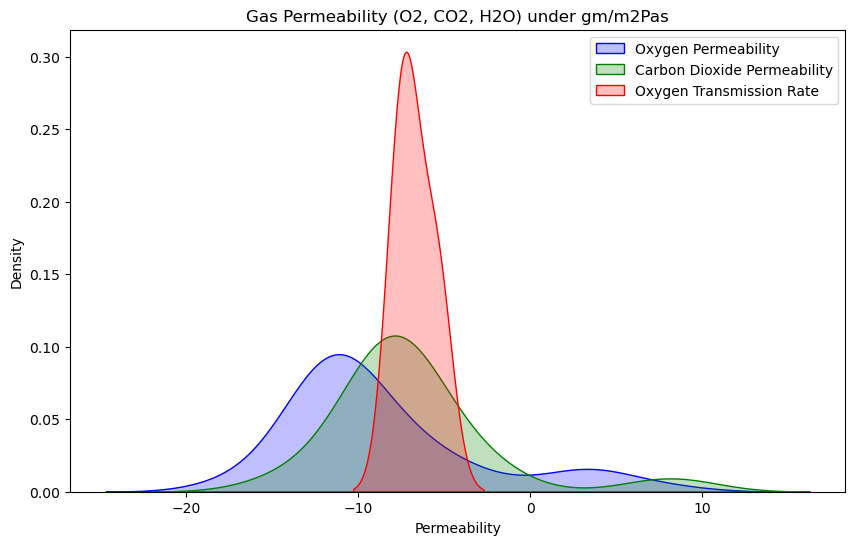

In [44]:
unit = 'cm3cm/m2Pas'

# Create a density plot for each gas permeability type
plt.figure(figsize=(10, 6))

tmp = clean_df[clean_df['Updated_Units'] == unit ]
f_tmp = tmp[tmp['Attached'].isin(['OP', 'OTR', 'PCO2'])]

f_tmp['Log_Updated_Number'] = np.log10(f_tmp['Updated_Number'])

# O2 Permeability Density Plot
sns.kdeplot(f_tmp[f_tmp['Attached'] == 'OP']['Log_Updated_Number'], label='Oxygen Permeability', color='blue', shade=True)

# CO2 Permeability Density Plot
sns.kdeplot(f_tmp[f_tmp['Attached'] == 'PCO2']['Log_Updated_Number'], label='Carbon Dioxide Permeability', color='green', shade=True)

# H2O Permeability Density Plot
# sns.kdeplot(f_tmp[f_tmp['Attached'] == 'OTR']['Log_Updated_Number'], label='Water Vapor Permeability', color='red', shade=True)
sns.kdeplot(f_tmp[f_tmp['Attached'] == 'OTR']['Log_Updated_Number'], label='Oxygen Transmission Rate', color='red', shade=True)

# Add labels and title
plt.title('Gas Permeability (O2, CO2, H2O) under gm/m2Pas')
plt.xlabel('Permeability')
plt.ylabel('Density')
plt.legend()

# Show plot
plt.show()

/var/folders/qs/8x1gpygd3nl0wldh8bphz0f80000gn/T/ipykernel_19165/1024689327.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_tmp['Log_Updated_Number'] = np.log10(f_tmp['Updated_Number'])


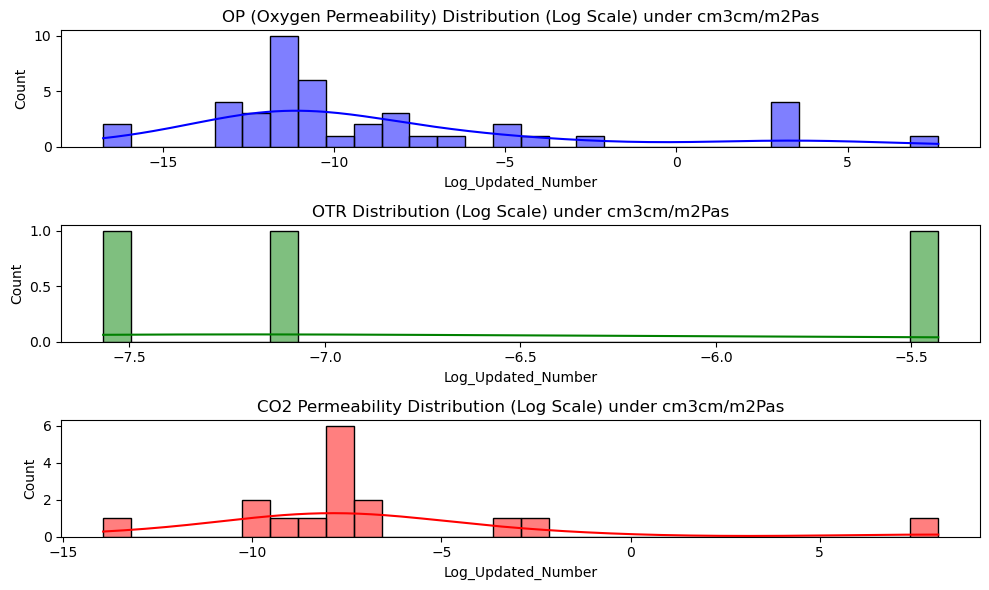

In [45]:
# Assuming the dataframe is named 'df'
unit = 'cm3cm/m2Pas'

tmp = clean_df[clean_df['Updated_Units'] == unit ]
f_tmp = tmp[tmp['Attached'].isin(['OP', 'OTR', 'PCO2'])]

f_tmp['Log_Updated_Number'] = np.log10(f_tmp['Updated_Number'])

# Step 3: Create a scatter plot for each gas type with log-scaled 'Updated_Number'
plt.figure(figsize=(10, 6))

# Histogram for OP Permeability (log scale)
plt.subplot(3, 1, 1)
sns.histplot(f_tmp[f_tmp['Attached'] == 'OP']['Log_Updated_Number'], bins=30, color='blue', kde=True)
plt.title('OP (Oxygen Permeability) Distribution (Log Scale) under ' + unit)

# Histogram for WVP Permeability (log scale)
plt.subplot(3, 1, 2)
sns.histplot(f_tmp[f_tmp['Attached'] == 'OTR']['Log_Updated_Number'], bins=30, color='green', kde=True)
# plt.title('WVP (Water Vapor Permeability) Distribution (Log Scale) under ' + unit)
plt.title('OTR Distribution (Log Scale) under ' + unit)

# Histogram for CO2 Permeability (log scale)
plt.subplot(3, 1, 3)
sns.histplot(f_tmp[f_tmp['Attached'] == 'PCO2']['Log_Updated_Number'], bins=30, color='red', kde=True)
plt.title('CO2 Permeability Distribution (Log Scale) under ' + unit)

# Add labels and adjust layout
# plt.xlabel('Log10(Updated Number)')
plt.tight_layout()
plt.show()




In [49]:
docs_with_permeability_uni = df[df['Target'] == 'permeability']['Doc'].unique()
docs_with_permeability = df[df['Doc'].isin(docs_with_permeability_uni)]

# Step 2: Find "Doc" values that do not have "permeability" in "Target"
# docs_without_permeability = df[~df['Doc'].isin(docs_with_permeability)]['Doc'].unique()
docs_without_permeability = df[~df['Doc'].isin(docs_with_permeability_uni)]
# Convert the result to a DataFrame for display
doc_dwp = docs_with_permeability.groupby(['Doc','Target']).size()
doc_dwop = docs_without_permeability.groupby(['Doc','Target']).size()
dwop = pd.DataFrame(doc_dwop).reset_index()
dwp = pd.DataFrame(doc_dwp).reset_index()
dwop.columns = ['Doc', 'Target', 'num']
dwp.columns = ['Doc', 'Target', 'num']

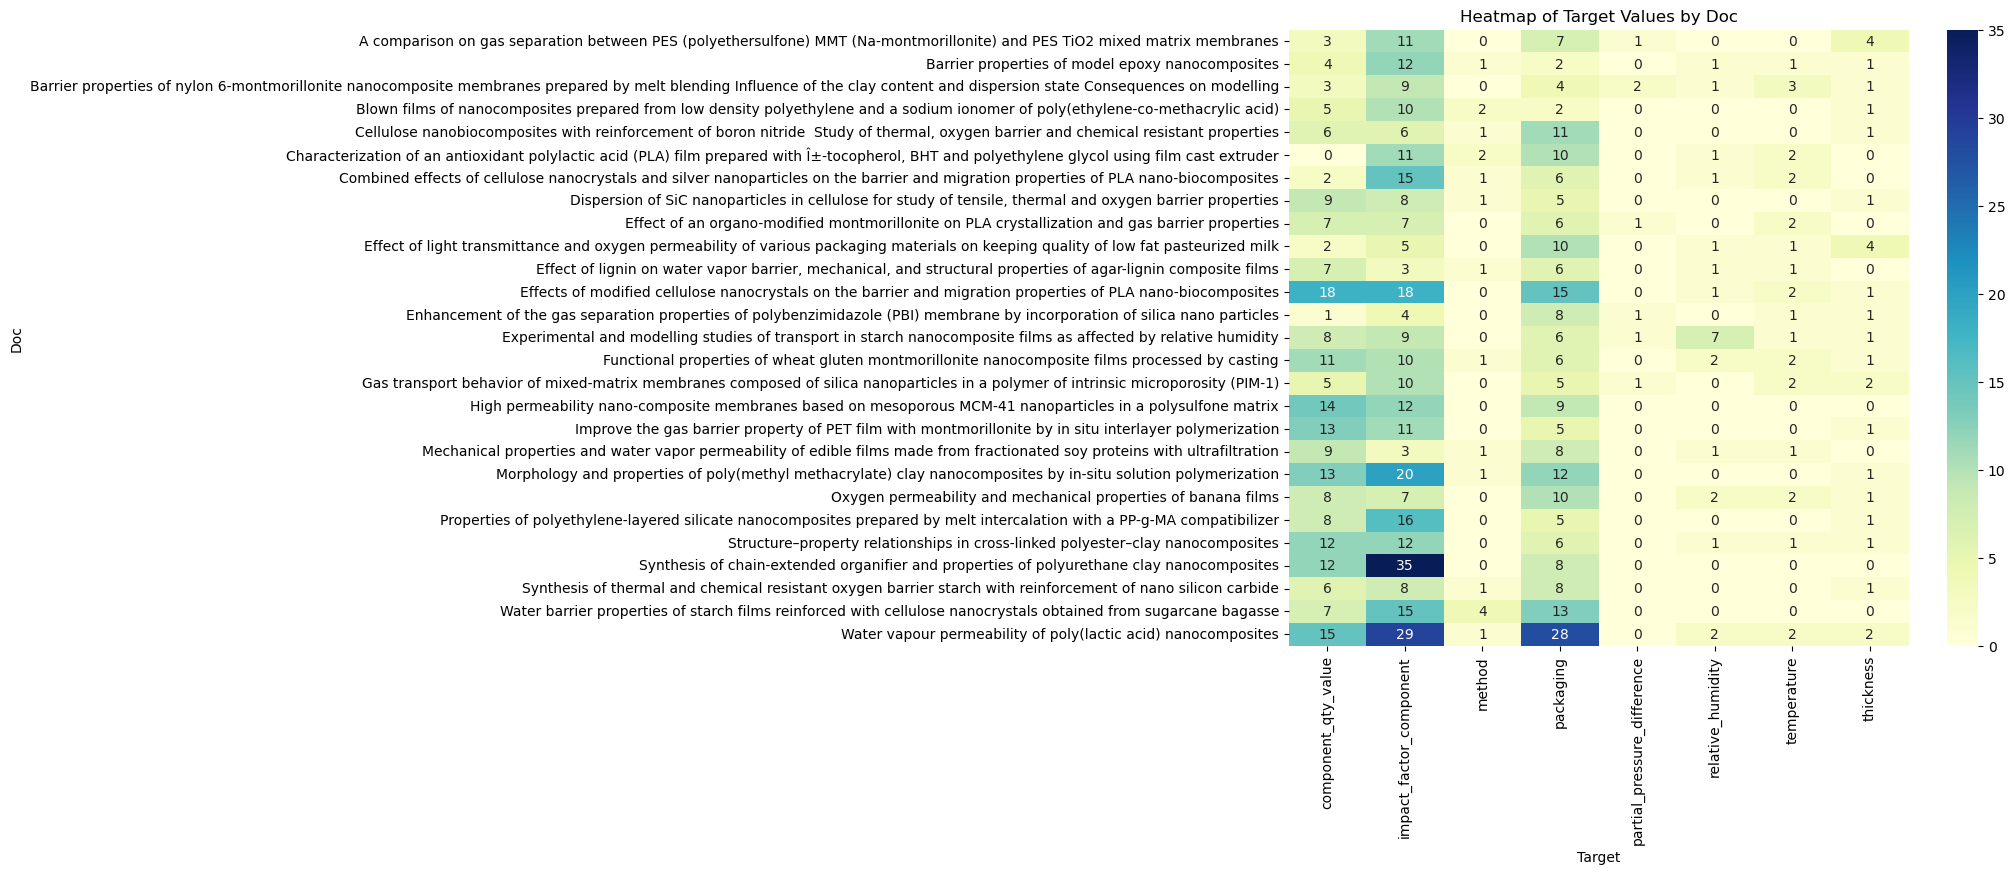

In [50]:
heatmap_data = dwop.pivot(index='Doc', columns='Target', values='num').fillna(0)
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Heatmap of Target Values by Doc')
plt.ylabel('Doc')
plt.xlabel('Target')
plt.show()

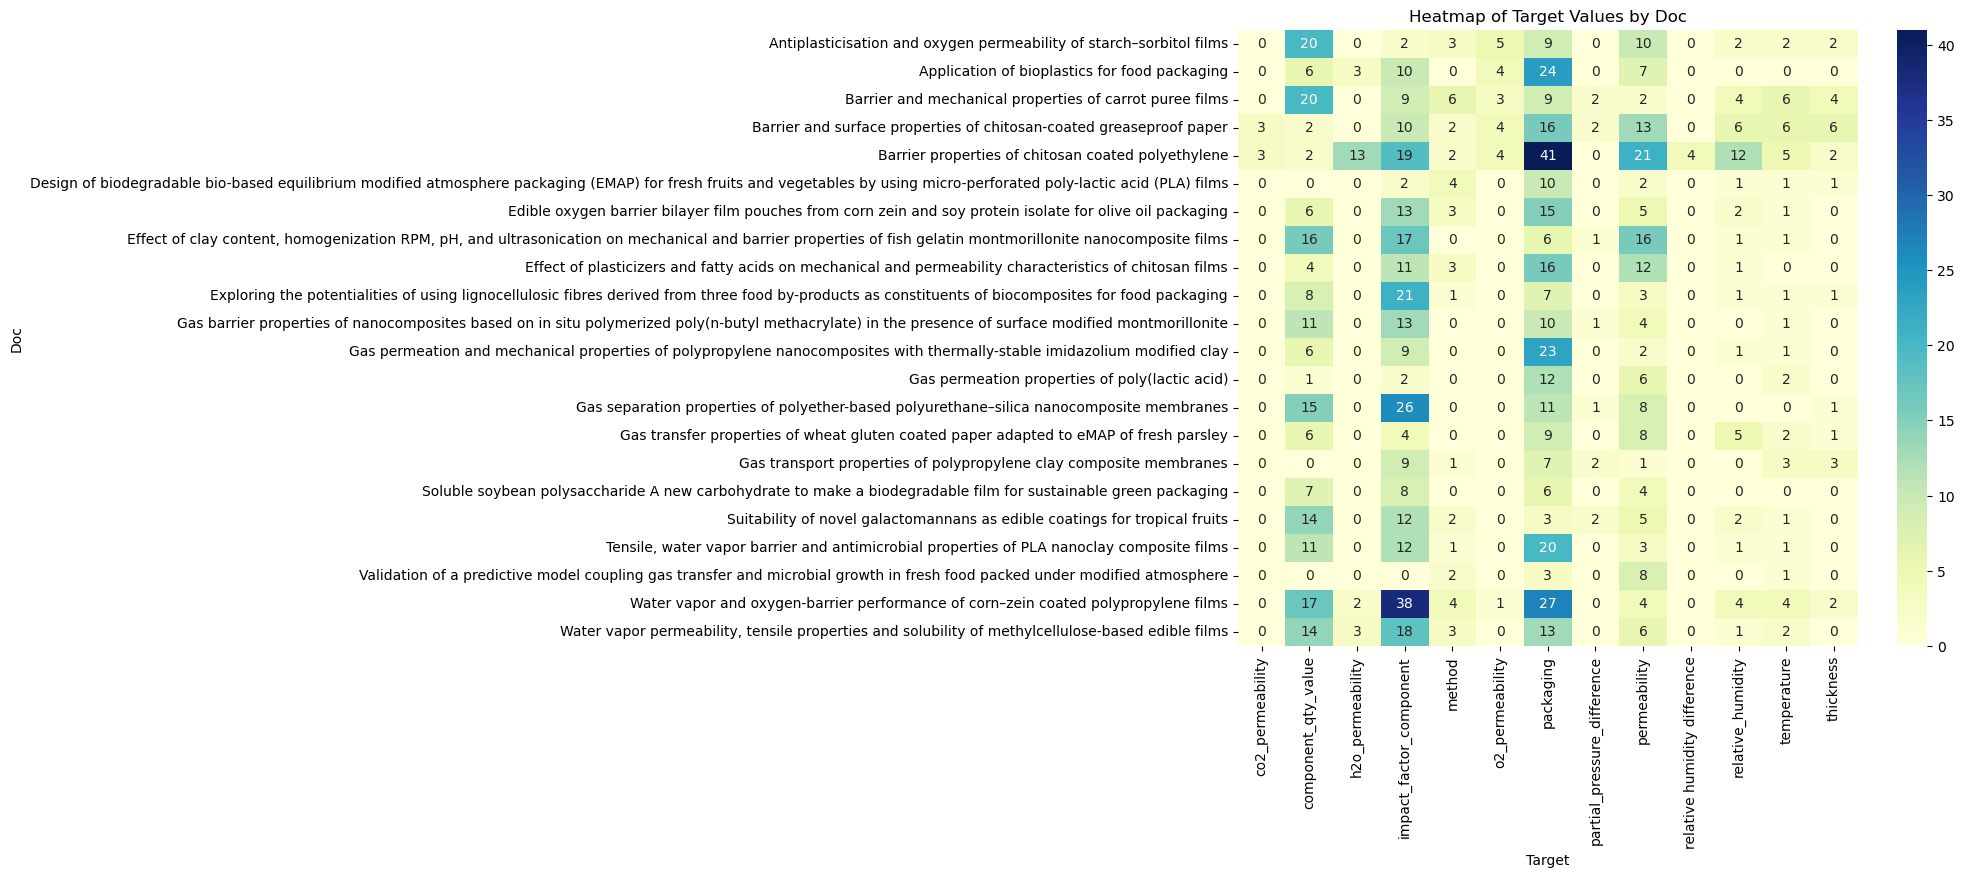

In [51]:
heatmap_data = dwp.pivot(index='Doc', columns='Target', values='num').fillna(0)
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Heatmap of Target Values by Doc')
plt.ylabel('Doc')
plt.xlabel('Target')
plt.show()